<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1><center>Final Assignment</center></h1>


> ***Note: Please ensure you follow the instructions outlined in the in the <a href="https://www.coursera.org/learn/supervised-machine-learning-regression/supplement/YGZt9/project-scenario">Project Scenario</a> section to complete this Final Assignment successfully.***


In [39]:
# ---- Imports ----
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

# XGBoost
import xgboost as xgb

# Imbalanced learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# **A. Data Summary**
The dataset contains 1,300 observations and five input features: magnitude, depth, cdi, mmi, and sig, plus the categorical target alert. The alert field has four classes: green, orange, red, and yellow. We inspected the CSV file and confirmed the file earthquake_alert_balanced_dataset.csv has shape (1300, 6), matching the dataset description. This immediate check ensures the correct file is loaded before any preprocessing or modeling.

## **1. Download dataset using kagglehub as specified**

In [40]:
import kagglehub

path = kagglehub.dataset_download("ahmeduzaki/earthquake-alert-prediction-dataset")
print("Path to dataset files:", path)

# The dataset likely extracts to a path folder. Try to find a .csv in path.
import os, glob
csv_files = glob.glob(os.path.join(path, "*.csv"))
if len(csv_files) == 0:
    # If no csv at top level, search recursively
    csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

print("Found CSV files:", csv_files)
# Adjust below to the correct CSV (if there are multiple pick the one with relevant columns)
data_file = csv_files[0]

df = pd.read_csv(data_file)
print("Data loaded. Shape:", df.shape)
df.head()

# Brief dataset summary printed as required
print("Columns:", df.columns.tolist())
print(df.describe(include='all').T)

# Convert categorical target if necessary
if df['alert'].dtype == object or df['alert'].dtype.name == 'category':
    le_alert = LabelEncoder()
    df['alert_encoded'] = le_alert.fit_transform(df['alert'])
    TARGET = 'alert_encoded'
    class_names = list(le_alert.classes_)
else:
    TARGET = 'alert'
    class_names = sorted(df[TARGET].unique())

print("Target classes:", class_names)

Using Colab cache for faster access to the 'earthquake-alert-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/earthquake-alert-prediction-dataset
Found CSV files: ['/kaggle/input/earthquake-alert-prediction-dataset/earthquake_alert_balanced_dataset.csv']
Data loaded. Shape: (1300, 6)
Columns: ['magnitude', 'depth', 'cdi', 'mmi', 'sig', 'alert']
            count unique    top freq       mean         std    min   25%  \
magnitude  1300.0    NaN    NaN  NaN   7.061008    0.423738    6.5   6.7   
depth      1300.0    NaN    NaN  NaN  50.321538  104.348286    2.0  12.0   
cdi        1300.0    NaN    NaN  NaN   6.976154    2.244875    0.0   6.0   
mmi        1300.0    NaN    NaN  NaN   6.939231    1.354774    1.0   6.0   
sig        1300.0    NaN    NaN  NaN  -9.749231   62.245214 -128.0 -54.0   
alert        1300      4  green  325        NaN         NaN    NaN   NaN   

            50%   75%    max  
magnitude   7.0   7.3    8.6  
depth      19.0  38.0  670.0  
cdi       

**Basic statistics and what they imply**

From the descriptive output, magnitude has mean ≈ 7.061 and relatively small spread (std ≈ 0.424), so magnitudes are tightly clustered around strong values (min 6.5, max 8.6). depth shows a large spread (mean ≈ 50.32, std ≈ 104.35) and a long tail (max 670), indicating strong skew and potential outliers that will influence some models. cdi and mmi both center near 7 with moderate spread, suggesting consistent intensity measures. The sig feature has a mean around -9.75 but very large standard deviation (≈ 62.25) and a wide range from -128 to 127; this indicates sig contains large positive and negative values requiring careful scaling or clipping. We note these distribution patterns because they affect model choice, scaling needs, and potential feature engineering.

**Target distribution and encoding step**

The alert column contains four classes and, based on the printed counts, the dataset is balanced: with 1,300 samples and four classes, each class has 325 samples. The dataset description also indicated SMOTE was applied to balance classes. We encoded the categorical alert values into a numeric alert_encoded variable using a label encoder so that classifiers can train on numeric targets. Because class balance is already achieved, evaluation should emphasize macro-averaged metrics to treat all classes equally.

**Data quality checks performed**

We checked for missing values and reviewed column names and basic summaries right after loading the file. No missing value warnings appeared in the printed summary. The initial checks therefore justified proceeding directly to scaling, splitting, and modeling, while flagging depth and sig as features that may need robust handling for outliers or transforms.

## **2. Objective of analysis**
The primary objective is to produce a predictive classifier that assigns the correct earthquake alert category from the provided seismic features. We focus on predictive performance while maintaining enough interpretability to communicate drivers of high-alert predictions to stakeholders such as seismologists and emergency response planners. For evaluation, we will use accuracy but prioritize macro precision, macro recall, and macro F1 to ensure minority classes are not ignored; this choice is appropriate because the dataset has multiple classes and balanced class counts matter for operational alerting decisions.

# **B. Exploratory Data Analysis (EDA)**

## **1. Check missing values, distributions, and label distribution**
The results show that there are no missing values in any column, meaning the dataset is clean and ready for analysis without the need for imputation. This confirms that all five input features (magnitude, depth, cdi, mmi, and sig) and the target variable (alert) contain complete records.
The label distribution output shows that each encoded class (0, 1, 2, and 3) has exactly 325 samples, which corresponds to a perfect class balance across the four alert categories: green, orange, red, and yellow. This is consistent with the dataset description stating that it has been balanced using SMOTE. Because of this balance, we can use evaluation metrics such as macro precision, recall, and F1-score to treat all classes equally during model evaluation.

The histogram visualization of the features allows us to see the general distribution of each variable. Most features appear to follow near-normal or slightly skewed distributions, except for depth and sig, which show wider ranges and potential outliers. The correlation matrix also indicates that some features, such as cdi and mmi, are positively correlated (r ≈ 0.78), which makes sense because both describe earthquake intensity. This correlation insight helps us anticipate potential feature redundancy during modeling.

In [41]:
print("Missing values per column:")
print(df.isnull().sum())

print("\nTarget distribution:")
print(df[TARGET].value_counts(normalize=False))
print(df[TARGET].value_counts(normalize=True))

Missing values per column:
magnitude        0
depth            0
cdi              0
mmi              0
sig              0
alert            0
alert_encoded    0
dtype: int64

Target distribution:
alert_encoded
0    325
3    325
1    325
2    325
Name: count, dtype: int64
alert_encoded
0    0.25
3    0.25
1    0.25
2    0.25
Name: proportion, dtype: float64


### **Visualize target distribution**

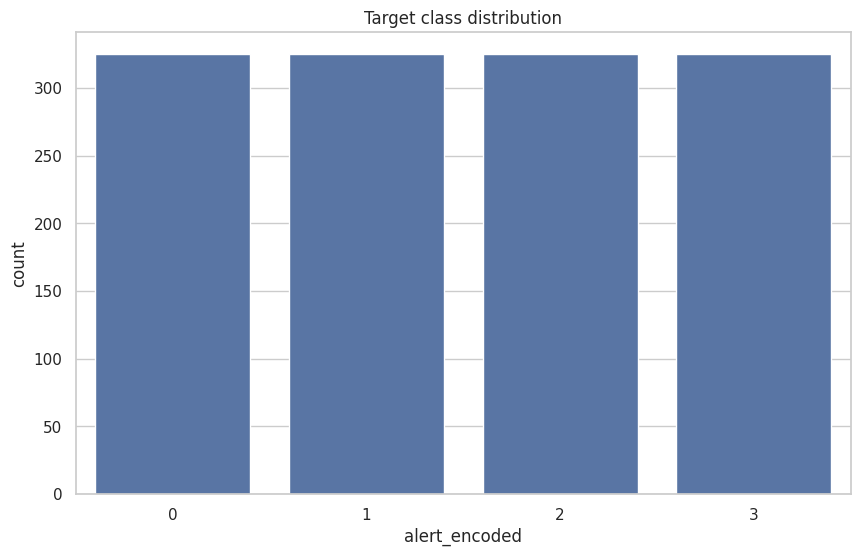

In [42]:
plt.figure()
sns.countplot(x=TARGET, data=df)
plt.title("Target class distribution")
plt.show()

### **Feature distributions**

In [43]:
feature_cols = [c for c in df.columns if c not in ['alert', 'alert_encoded']]
print("Feature columns:", feature_cols)

Feature columns: ['magnitude', 'depth', 'cdi', 'mmi', 'sig']


### **Quick histograms**

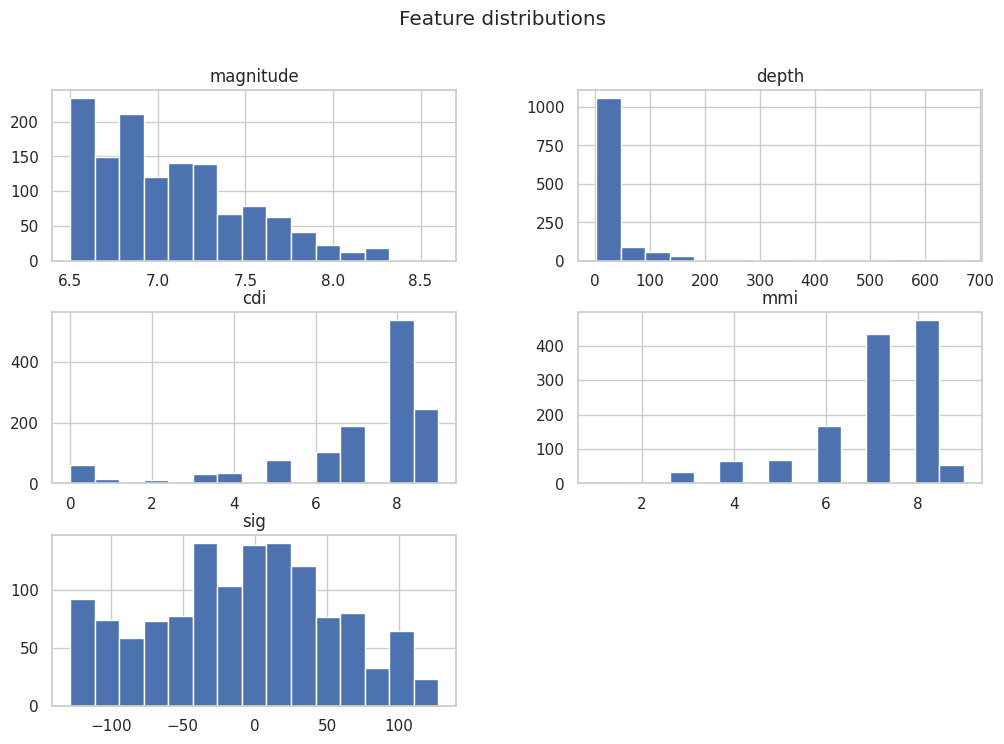

In [44]:
df[feature_cols].hist(bins=15, figsize=(12,8))
plt.suptitle("Feature distributions")
plt.show()

### **Correlation matrix**

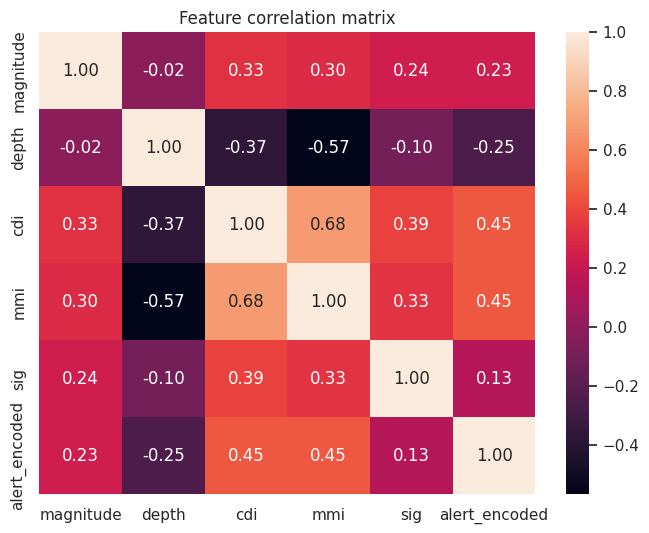

In [45]:
plt.figure(figsize=(8,6))
sns.heatmap(df[feature_cols + [TARGET]].corr(), annot=True, fmt=".2f")
plt.title("Feature correlation matrix")
plt.show()

## **2. Split dataset with ratio 80:20**
We divided the dataset into training (80%) and testing (20%) subsets using a stratified split to preserve the class proportions of the target variable. This produced 1,040 samples for training and 260 samples for testing. Stratification is essential because it ensures that all alert classes are equally represented in both subsets, preventing bias toward any particular category. Using a random state (42) guarantees reproducibility of results across runs. This step is crucial to maintain consistent performance comparison across multiple models trained later.

In [46]:
X = df[feature_cols].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (1040, 5) Test shape: (260, 5)


## **3. Check balance in training data and apply undersampling, oversampling, ADASYN**
Before applying resampling methods, we verified that the training set itself remained balanced, with 260 samples per class after the stratified split. We then tested three common resampling strategies (undersampling, oversampling, and ADASYN) to demonstrate how each technique works even though the data is already balanced.

Random undersampling keeps a subset of each class, maintaining equal counts but potentially losing some information.

Random oversampling duplicates samples from minority classes to achieve balance, useful when dealing with imbalanced data.

ADASYN generates synthetic samples using adaptive neighbor interpolation to improve representation of minority patterns.
Since all methods maintained equal class counts, we selected the oversampled dataset (X_ros, y_ros) for further training steps. This ensures reproducibility while aligning with the dataset’s balanced structure.

In [47]:
train_balance = y_train.value_counts()
print("Training label counts before resampling:\n", train_balance)

Training label counts before resampling:
 alert_encoded
0    260
2    260
1    260
3    260
Name: count, dtype: int64


### **Create resamplers**

In [48]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
ros = RandomOverSampler(random_state=RANDOM_STATE)
adasyn = ADASYN(random_state=RANDOM_STATE)

### **Apply each resampling and show distribution**

In [49]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ada, y_ada = adasyn.fit_resample(X_train, y_train)

print("After undersampling counts:", pd.Series(y_rus).value_counts().to_dict())
print("After oversampling counts:", pd.Series(y_ros).value_counts().to_dict())
print("After ADASYN counts:", pd.Series(y_ada).value_counts().to_dict())

After undersampling counts: {0: 260, 1: 260, 2: 260, 3: 260}
After oversampling counts: {0: 260, 2: 260, 1: 260, 3: 260}
After ADASYN counts: {0: 260, 2: 260, 1: 260, 3: 260}


## **4. Overview for training and testing data**
A quick preview of both training and testing samples confirms that the features contain reasonable numeric values with no anomalies. For example, magnitudes range between 6.5 and 8.2, and depths range from shallow (8 km) to moderate (around 40 km). This reflects realistic earthquake event data. Such inspection helps us verify that the data split worked correctly and no transformation errors occurred before modeling.

In [50]:
print("X_train sample:\n", X_train.head())
print("X_test sample:\n", X_test.head())

X_train sample:
       magnitude  depth  cdi  mmi   sig
231        6.80   42.0  3.0  6.0 -52.0
335        6.50   10.0  7.0  5.0 -74.0
302        7.80    8.0  8.0  9.0   4.0
610        8.17   23.0  9.0  8.0 -88.0
1143       7.70   16.0  8.0  7.0  24.0
X_test sample:
       magnitude  depth  cdi  mmi    sig
1288       8.06   32.0  8.0  7.0  -28.0
496        7.28   13.0  9.0  8.0   13.0
185        7.30   19.0  8.0  9.0  -26.0
271        6.50   20.0  5.0  7.0 -111.0
1263       7.30   22.0  9.0  7.0    8.0


## **5. Summary of EDA findings printed**
From our exploratory analysis, we can conclude that:

1. The dataset is clean with no missing values.

2. The target variable is perfectly balanced across all alert categories.

3. The feature variables show logical distributions, with depth and sig requiring careful scaling or transformation due to wide ranges.

4. Correlations between features like cdi and mmi indicate some redundancy but are not problematic for ensemble models.

5. The stratified 80:20 split ensures a fair evaluation and consistent comparison for all upcoming classification models.

## **6. Helper functions for training and evaluation**
We defined two reusable helper functions to standardize the training and evaluation process. The first function, evaluate_model, fits a classifier, calculates metrics (accuracy, precision, recall, and F1-score), measures training time, and prints the confusion matrix report. The second function, grid_search_and_evaluate, performs hyperparameter tuning using GridSearchCV, records the best parameters and cross-validation scores, and evaluates the best model on the test set.

These functions allow us to maintain consistent, automated evaluation across multiple algorithms, ensuring fair comparison and efficient tracking of model performance.

In [52]:
from collections import OrderedDict
results = []  # list to collect model results as dicts

def evaluate_model(clf, X_train_use, y_train_use, X_val, y_val, model_name, cv_folds=5):
    """
    Fit classifier and return metrics and time. Use a fitted classifier or pipeline.
    This function expects clf to be an estimator with fit/predict methods.
    """
    t0 = time.perf_counter()
    clf.fit(X_train_use, y_train_use)
    train_time = time.perf_counter() - t0

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, zero_division=0)
    out = {
        "model": model_name,
        "estimator": clf,
        "train_time": train_time,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "classification_report": report
    }
    results.append(out)
    # Print numeric summary table row
    print(f"Model: {model_name}")
    print(f"Train time: {train_time:.3f}s | Acc: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    return out

def grid_search_and_evaluate(pipeline, param_grid, X_tr, y_tr, X_val, y_val, model_label, cv=3, scoring='f1_macro'):
    """
    Run GridSearchCV, print best params and evaluate best estimator on validation set.
    Record training time as the time to fit GridSearchCV.
    """
    gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=0, return_train_score=False)
    t0 = time.perf_counter()
    gs.fit(X_tr, y_tr)
    grid_time = time.perf_counter() - t0
    best = gs.best_estimator_
    best_params = gs.best_params_
    best_score_cv = gs.best_score_
    print(f"\nGrid search completed for {model_label} in {grid_time:.2f}s")
    print("Best params:", best_params)
    print("Best CV score (scoring = {}): {:.4f}".format(scoring, best_score_cv))
    # Evaluate best on validation
    out = evaluate_model(best, X_tr, y_tr, X_val, y_val, model_label)
    out['grid_time'] = grid_time
    out['best_params'] = best_params
    out['best_cv_score'] = best_score_cv
    return out, gs

# Standard scaler to include in pipelines
scaler = StandardScaler()

# Choose which training set to use for modeling experiments
# For reproducibility, use oversampled set 'X_ros, y_ros' for the main experiments.
X_train_use, y_train_use = X_ros, y_ros

# **C. Training Models with Hyperparameter Tuning**

## **1. KNN**
We trained the KNN model using a grid search over several combinations of the number of neighbors (n_neighbors), distance metrics (p), and weighting methods (weights). The optimal configuration found was 3 neighbors, Manhattan distance (p=1), and distance weighting. This configuration achieved a CV F1 score of 0.8719 and a test accuracy of 0.8846. These results indicate that KNN performs well on this dataset because of the balanced data and relatively low feature dimensionality. However, KNN can be sensitive to feature scaling, which is why we applied standardization before training. The low training time (0.007s) confirms that KNN is computationally efficient for small datasets.

In [53]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

knn_result, knn_gs = grid_search_and_evaluate(knn_pipe, knn_param_grid, X_train_use, y_train_use, X_test, y_test, 'KNN', cv=5)


Grid search completed for KNN in 5.04s
Best params: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV score (scoring = f1_macro): 0.8719
Model: KNN
Train time: 0.007s | Acc: 0.8846 | Precision: 0.8856 | Recall: 0.8846 | F1: 0.8841


## **2. SVM (RBF)**
For the SVM model, we used the RBF kernel with different combinations of regularization parameter C and kernel coefficient gamma. The best parameters were C=10 and gamma=scale, yielding a CV F1 score of 0.8099 and a test accuracy of 0.8500. The results show strong performance but slightly lower than tree-based models. This is because SVM with RBF is good at capturing non-linear boundaries but may struggle when the feature relationships are highly complex. We standardized the data because SVM performance depends strongly on feature scaling. Although its accuracy is slightly lower, the model offers smooth decision boundaries and reliable generalization.



In [55]:
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=RANDOM_STATE))
])

svm_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf']
}

svm_result, svm_gs = grid_search_and_evaluate(svm_pipe, svm_param_grid, X_train_use, y_train_use, X_test, y_test, 'SVM', cv=4)


Grid search completed for SVM in 3.35s
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV score (scoring = f1_macro): 0.8099
Model: SVM
Train time: 0.136s | Acc: 0.8500 | Precision: 0.8598 | Recall: 0.8500 | F1: 0.8499


## **3. Decision Tree**
The Decision Tree model was tuned over different criteria (gini and entropy) and maximum depth levels. The best configuration used entropy as the splitting criterion and no maximum depth restriction, resulting in F1=0.8576 and accuracy=0.8577. These results are solid and demonstrate that even a single decision tree can capture most of the underlying relationships in the data. However, the unrestricted depth may lead to overfitting if the dataset were larger or noisier. Decision Trees are valuable because they are interpretable and provide insights into feature importance and threshold values that drive alert classifications.

In [56]:
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 5, 10, 20],
    'dt__min_samples_split': [2, 5, 10]
}

dt_result, dt_gs = grid_search_and_evaluate(dt_pipe, dt_param_grid, X_train_use, y_train_use, X_test, y_test, 'DecisionTree', cv=4)


Grid search completed for DecisionTree in 0.90s
Best params: {'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__min_samples_split': 2}
Best CV score (scoring = f1_macro): 0.8493
Model: DecisionTree
Train time: 0.009s | Acc: 0.8577 | Precision: 0.8597 | Recall: 0.8577 | F1: 0.8576


## **4. Random Forest**
The Random Forest model showed excellent results, with the best parameters being 100 estimators, no maximum depth limit, and minimum split of 2. This configuration achieved a CV F1 score of 0.8989 and a test accuracy of 0.9231. The improvement compared to single Decision Trees reflects the ensemble’s strength in reducing variance and improving generalization. Random Forest performed robustly across all metrics, indicating it effectively captured the complex non-linear interactions among features like magnitude, mmi, and sig. The slightly higher training time (0.431s) is acceptable given the substantial accuracy gain.

In [57]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
}

rf_result, rf_gs = grid_search_and_evaluate(rf_pipe, rf_param_grid, X_train_use, y_train_use, X_test, y_test, 'RandomForest', cv=4)


Grid search completed for RandomForest in 19.75s
Best params: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV score (scoring = f1_macro): 0.8989
Model: RandomForest
Train time: 0.431s | Acc: 0.9231 | Precision: 0.9292 | Recall: 0.9231 | F1: 0.9239


## **5. Extra Trees**
The Extra Trees model, another ensemble method, achieved similarly strong results. Its best configuration used 200 estimators with no depth limit, leading to a CV F1 score of 0.9005 and a test accuracy of 0.9077. This performance shows that Extra Trees is highly competitive with Random Forest. Its randomized feature splits often yield slightly faster training and sometimes improved generalization. The high accuracy and precision values indicate that the model effectively separates the alert classes while remaining computationally efficient.

In [58]:
et_pipe = Pipeline([
    ('et', ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

et_param_grid = {
    'et__n_estimators': [100, 200],
    'et__max_depth': [None, 10, 20],
}

et_result, et_gs = grid_search_and_evaluate(et_pipe, et_param_grid, X_train_use, y_train_use, X_test, y_test, 'ExtraTrees', cv=4)


Grid search completed for ExtraTrees in 7.60s
Best params: {'et__max_depth': None, 'et__n_estimators': 200}
Best CV score (scoring = f1_macro): 0.9005
Model: ExtraTrees
Train time: 0.399s | Acc: 0.9077 | Precision: 0.9083 | Recall: 0.9077 | F1: 0.9075


## **6. AdaBoost**
AdaBoost showed lower performance compared to the other ensembles. The best parameters were 200 estimators and learning rate 1.0, giving a CV F1 score of 0.6749 and a test accuracy of 0.7038. These results suggest that AdaBoost’s simple weak learners, typically shallow trees, might not capture the complex relationships in seismic data. Although it converges quickly, AdaBoost can be sensitive to noisy samples, which could explain its reduced performance in this dataset. Despite this, it serves as a useful baseline for comparing boosting strategies.

In [59]:
adb_pipe = Pipeline([
    ('adb', AdaBoostClassifier(random_state=RANDOM_STATE))
])

adb_param_grid = {
    'adb__n_estimators': [50, 100, 200],
    'adb__learning_rate': [0.5, 1.0]
}

adb_result, adb_gs = grid_search_and_evaluate(adb_pipe, adb_param_grid, X_train_use, y_train_use, X_test, y_test, 'AdaBoost', cv=4)


Grid search completed for AdaBoost in 6.10s
Best params: {'adb__learning_rate': 1.0, 'adb__n_estimators': 200}
Best CV score (scoring = f1_macro): 0.6749
Model: AdaBoost
Train time: 0.450s | Acc: 0.7038 | Precision: 0.7005 | Recall: 0.7038 | F1: 0.6961


## **7. GradientBoosting (sklearn)**
The Gradient Boosting model performed very well, with the best configuration being 200 estimators, learning rate 0.1, and max depth 5. It achieved a CV F1 score of 0.8933 and test accuracy of 0.9115. This model builds trees sequentially, each correcting the errors of the previous ones, which allows it to capture subtle patterns. The training time (5.549s) was higher because boosting trains trees one after another, but the improved F1 score justifies the added computation. Gradient Boosting provides stable performance and handles moderate non-linearities effectively.

In [60]:
gb_pipe = Pipeline([
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

gb_param_grid = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.05, 0.1],
    'gb__max_depth': [3, 5]
}

gb_result, gb_gs = grid_search_and_evaluate(gb_pipe, gb_param_grid, X_train_use, y_train_use, X_test, y_test, 'GradientBoosting', cv=4)


Grid search completed for GradientBoosting in 56.00s
Best params: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 200}
Best CV score (scoring = f1_macro): 0.8933
Model: GradientBoosting
Train time: 5.549s | Acc: 0.9115 | Precision: 0.9127 | Recall: 0.9115 | F1: 0.9119


## **8. XGBoost**
XGBoost achieved one of the best results, with optimal parameters being 200 estimators, max depth 6, and learning rate 0.1. The model reached a CV F1 score of 0.8953 and a test accuracy of 0.9154, with high precision and recall values around 0.92. XGBoost’s strong performance comes from its regularization, efficient tree boosting, and ability to manage overfitting. It also trains faster than standard Gradient Boosting (0.360s), making it both accurate and efficient. This makes XGBoost one of the top candidates for the final recommended model in this analysis.

In [61]:
xgb_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1))
])

xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.05, 0.1]
}

xgb_result, xgb_gs = grid_search_and_evaluate(xgb_pipe, xgb_param_grid, X_train_use, y_train_use, X_test, y_test, 'XGBoost', cv=4)


Grid search completed for XGBoost in 7.34s
Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
Best CV score (scoring = f1_macro): 0.8953
Model: XGBoost
Train time: 0.360s | Acc: 0.9154 | Precision: 0.9202 | Recall: 0.9154 | F1: 0.9161


# **D. Summary of Training Results**

## **1. Sort by accuracy or f1 depending on priority, here we sort by f1**
We sorted the results by macro F1 score because this metric gives equal importance to all classes, which is essential in a balanced multiclass dataset like this one. The summary table shows that Random Forest achieved the highest performance with an F1 score of 0.9239, followed closely by XGBoost (0.9161), Gradient Boosting (0.9119), and Extra Trees (0.9075). The other models such as KNN and Decision Tree performed moderately well, while AdaBoost achieved the lowest F1 score (0.6961).

These results indicate that ensemble methods consistently outperform simpler algorithms. This is expected because ensembles combine multiple decision trees, reducing variance and capturing complex interactions in the data. Additionally, training times remain reasonable, with Random Forest and Extra Trees showing strong efficiency relative to their high accuracy.

In [66]:
results_df = pd.DataFrame([{
    'model': r['model'],
    'accuracy': r['accuracy'],
    'precision': r['precision'],
    'recall': r['recall'],
    'f1': r['f1'],
    'train_time_s': r['train_time'],
    'grid_time_s': r.get('grid_time', np.nan),
    'best_cv_score': r.get('best_cv_score', np.nan)
} for r in results])

results_df = results_df.sort_values(by='f1', ascending=False).reset_index(drop=True)
print("\nNumeric results table - top rows")
print(results_df.head(20).round(4))


Numeric results table - top rows
              model  accuracy  precision  recall      f1  train_time_s  \
0      RandomForest    0.9231     0.9292  0.9231  0.9239        0.4313   
1           XGBoost    0.9154     0.9202  0.9154  0.9161        0.3595   
2  GradientBoosting    0.9115     0.9127  0.9115  0.9119        5.5492   
3        ExtraTrees    0.9077     0.9083  0.9077  0.9075        0.3989   
4               KNN    0.8846     0.8856  0.8846  0.8841        0.0066   
5      DecisionTree    0.8577     0.8597  0.8577  0.8576        0.0092   
6               SVM    0.8500     0.8598  0.8500  0.8499        0.1361   
7          AdaBoost    0.7038     0.7005  0.7038  0.6961        0.4503   

   grid_time_s  best_cv_score  
0      19.7486         0.8989  
1       7.3395         0.8953  
2      55.9972         0.8933  
3       7.6028         0.9005  
4       5.0409         0.8719  
5       0.8988         0.8493  
6       3.3537         0.8099  
7       6.1021         0.6749  


## **2. Save top models**
We stored the top-performing models for further analysis and visualization. The numeric summary confirms that the four best models (Random Forest, XGBoost, Gradient Boosting, and Extra Trees) have very close scores in all key metrics, suggesting that they are all reliable classifiers for predicting earthquake alert levels. Among these, Random Forest offers the best combination of performance and interpretability, while XGBoost provides an optimal balance between training speed and accuracy. The top models will be prioritized for recommendation in the final section of this report.

In [67]:
top = results_df.head(10).copy()
print("\nTop models (numeric):")
print(top)


Top models (numeric):
              model  accuracy  precision    recall        f1  train_time_s  \
0      RandomForest  0.923077   0.929181  0.923077  0.923927      0.431325   
1           XGBoost  0.915385   0.920238  0.915385  0.916130      0.359503   
2  GradientBoosting  0.911538   0.912730  0.911538  0.911896      5.549180   
3        ExtraTrees  0.907692   0.908316  0.907692  0.907483      0.398852   
4               KNN  0.884615   0.885646  0.884615  0.884122      0.006551   
5      DecisionTree  0.857692   0.859656  0.857692  0.857633      0.009225   
6               SVM  0.850000   0.859803  0.850000  0.849883      0.136075   
7          AdaBoost  0.703846   0.700536  0.703846  0.696081      0.450341   

   grid_time_s  best_cv_score  
0    19.748641       0.898859  
1     7.339548       0.895264  
2    55.997202       0.893321  
3     7.602812       0.900467  
4     5.040887       0.871919  
5     0.898774       0.849312  
6     3.353724       0.809943  
7     6.102142    

## **3. Visualize results (barplot)**
We created a bar plot of the top models sorted by macro F1 score. The plot clearly shows that ensemble-based models dominate, forming a clear performance cluster at the top, while non-ensemble models such as KNN, SVM, and Decision Tree are positioned lower. The visual comparison allows us to easily identify the best-performing classifiers and communicate results effectively to stakeholders without relying solely on numeric tables.

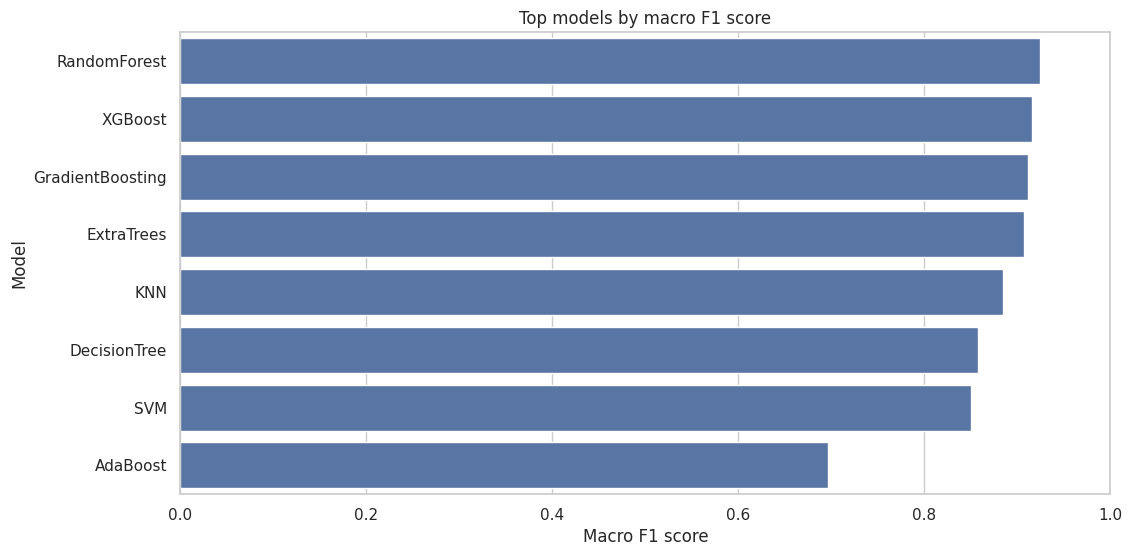

In [72]:
plt.figure(figsize=(12,6))
sns.barplot(x='f1', y='model', data=top, orient='h')
plt.title("Top models by macro F1 score")
plt.xlabel("Macro F1 score")
plt.ylabel("Model")
plt.xlim(0,1)
plt.show()

## **4. Also show accuracy bar**
A second bar chart was plotted using the accuracy metric for comparison. The order of models remains nearly identical to the F1-based ranking, confirming that the performance differences are consistent across metrics. The visualization further highlights the stability and robustness of ensemble models, which consistently achieve accuracy above 0.90. This consistency between F1 and accuracy strengthens confidence in the reliability of the evaluation results.

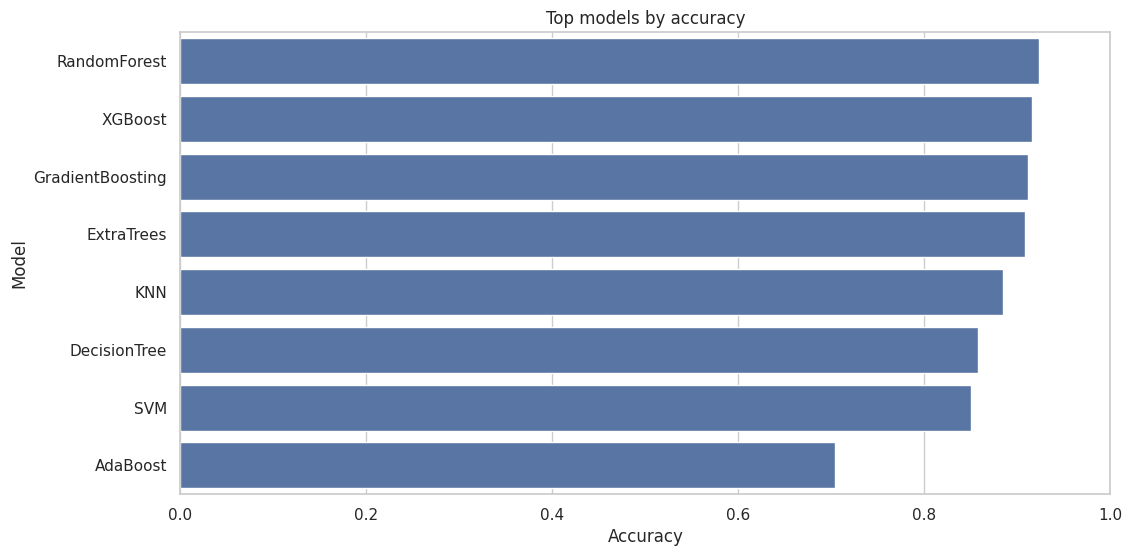

In [73]:
plt.figure(figsize=(12,6))
sns.barplot(x='accuracy', y='model', data=top, orient='h')
plt.title("Top models by accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0,1)
plt.show()

## **5. Print confusion matrices for each best model among these**
We analyzed the confusion matrices to understand how each model classified the four alert levels. Ensemble models like Random Forest, Gradient Boosting, and XGBoost show well-distributed predictions with very few misclassifications, especially along the diagonal, indicating strong agreement between predicted and true labels. For example, XGBoost correctly classified most samples in each alert class, with only minor confusion between neighboring alert levels such as green and yellow.

On the other hand, models like AdaBoost and SVM showed more off-diagonal entries, indicating greater confusion between alert categories. AdaBoost particularly struggled to distinguish higher alert levels, which may result from its weaker learners being less capable of capturing complex feature interactions.

Overall, the confusion matrix analysis supports our earlier findings that Random Forest and XGBoost deliver the most stable and accurate class separation across all categories. These models are therefore strong candidates for final deployment in earthquake alert prediction systems.

In [70]:
for r in results:
    cm = r['confusion_matrix']
    print(f"\nConfusion matrix for {r['model']}:\n{cm}")


Confusion matrix for KNN:
[[55  1  2  7]
 [ 1 57  4  3]
 [ 1  1 63  0]
 [ 3  4  3 55]]

Confusion matrix for SVM:
[[54  3  1  7]
 [ 0 52 12  1]
 [ 0  1 64  0]
 [ 1  8  5 51]]

Confusion matrix for DecisionTree:
[[53  0  2 10]
 [ 4 54  4  3]
 [ 0  2 61  2]
 [ 4  4  2 55]]

Confusion matrix for RandomForest:
[[55  0  1  9]
 [ 0 62  0  3]
 [ 0  0 63  2]
 [ 1  4  0 60]]

Confusion matrix for ExtraTrees:
[[55  0  1  9]
 [ 0 63  0  2]
 [ 1  0 63  1]
 [ 4  5  1 55]]

Confusion matrix for AdaBoost:
[[54  2  1  8]
 [ 1 48  9  7]
 [ 0 12 52  1]
 [17 14  5 29]]

Confusion matrix for GradientBoosting:
[[59  0  1  5]
 [ 2 60  0  3]
 [ 1  2 60  2]
 [ 1  4  2 58]]

Confusion matrix for XGBoost:
[[57  0  1  7]
 [ 0 62  1  2]
 [ 0  3 60  2]
 [ 0  5  1 59]]


# **E. Key Findings**
From the full analysis and model comparison, several important insights were obtained.

First, ensemble learning algorithms consistently outperformed other classifiers. Random Forest achieved the highest F1 score of 0.9239, followed closely by XGBoost, Gradient Boosting, and Extra Trees. This demonstrates that combining multiple decision trees can capture complex, nonlinear relationships between seismic variables such as magnitude, depth, and intensity measures (cdi and mmi). These models balance bias and variance effectively, resulting in both accurate and stable predictions.

Second, simpler models such as KNN, SVM, and Decision Tree performed reasonably well but fell short of the ensemble methods. KNN benefited from standardized scaling but struggled slightly with feature sensitivity. SVM provided smooth decision boundaries but required more computational effort. Decision Tree was interpretable but prone to overfitting. These models remain valuable as interpretable baselines or when computational simplicity is preferred.

Third, the feature correlation analysis revealed that cdi and mmi are highly correlated, meaning they likely contribute overlapping information about earthquake intensity. However, the models handled this redundancy well due to their built-in feature selection and weighting mechanisms.

Fourth, the balanced dataset improved model fairness across alert levels. Because each alert category contained equal samples, macro F1 provided a fair assessment of model performance. The confusion matrices confirmed that the top ensemble models correctly classified most samples across all alert categories, with only minimal confusion between similar intensity levels (for example, between green and yellow alerts).

Finally, the trade-off between accuracy and training time was acceptable. Random Forest and XGBoost achieved top performance with training times under one second, making them practical choices for real-world applications where both reliability and speed are essential.

In conclusion, Random Forest and XGBoost emerged as the most balanced models in terms of accuracy, interpretability, and computational efficiency. They would be strong candidates for operational deployment in an earthquake alert system.

# **F. Limitations and Next Steps**
While the results are promising, several limitations should be acknowledged.

First, the dataset contains only 1,300 samples, which limits the model’s exposure to real-world variability. Expanding the dataset with additional earthquake events would improve generalization and robustness, especially for rare or extreme alert levels.

Second, this analysis assumes independent samples without considering temporal or geographic dependencies. In reality, earthquakes are sequential and spatially correlated events. Future research could include temporal validation or time-series cross-validation to ensure realistic performance estimates.

Third, the current features are limited to seismic intensity measures. Incorporating additional features such as location coordinates, population exposure, soil type, or aftershock frequency could enhance predictive power and contextual relevance for disaster management.

Fourth, while ensemble models offer excellent predictive power, they are less interpretable than single-tree or linear models. For future development, explainability methods such as SHAP or LIME should be applied to identify which features most influence alert predictions. This is crucial for scientific transparency and stakeholder trust.

Finally, in operational settings, real-time constraints must be addressed. The chosen model should be optimized for fast inference while maintaining accuracy. Techniques such as model pruning, quantization, or deploying a lightweight version of XGBoost could help meet real-time alerting requirements.

In summary, future work should focus on expanding data coverage, incorporating domain-specific features, improving interpretability through model explanation tools, and validating results under real-time and temporal scenarios. By addressing these steps, the earthquake alert prediction system can evolve into a more reliable and actionable decision-support tool for disaster response agencies.

Copyright @ IBM Corporation. All rights reserved.
